<a href="https://colab.research.google.com/github/surajsrivathsa/deep_learning_paper_implementations/blob/master/MRI_T1_T2_contrast_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Program setup**

1. Setup and mount relevant drive paths that has images, models etc
2. Import libraries and download them if they are not existing.
3. Read the image folders of T1 and T2 and put their paths in a list for further procesisng.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# importing necessary libraries

!pip install nilearn
import torch
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/")
from nilearn.image import resample_img
import pylab as plt
import nibabel as nb
import numpy as np
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

     |████████████████████████████████| 2.5MB 4.3MB/s 


In [ ]:
!pip install SimpleITK
import SimpleITK as sitk

     |████████████████████████████████| 42.5MB 72kB/s 


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from statistics import mean
from torch.autograd import Variable
import time
from PIL import Image
import random
from skimage import io, transform
from collections import OrderedDict
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from torchsummary import summary
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv3d, MaxPool3d, Module, Softmax, BatchNorm3d, Dropout
from torch.optim import Adam, SGD
from matplotlib import pyplot as plt
from skimage import io, transform
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Any results you write to the current directory are saved as output.

In [ ]:
import torch
from torch.autograd import Variable 

# **Create a custom dataset, patches class and dataloader for nii images**

**Custom Dataset and Dataloader**

1. Extend torch.dataset and dataloader and use it as our own nii data
2. in Init initialize any transforms like cropping/padding/rotation. Currently we have not applied any transform, but one can be applied to patches.
3. in len function get length of dataset
4. getitem(index) returns image and label of each image and applied initialized transforms like cropping/rotation/patching.
5. Pipe it to data loader and use less batches to save memory.


**Patching**

1. Extract cube patches of (32 * 32 * 32) from T1 and T2 images correspondingly.
2. Each cube patch of T1 must correspond to patch of T2
3. (T1_patch, T2_patch) should be returned by __getitem__(index) function.

**Bugs**

1. Currently we have implemented custom dataset class in such a way that it can work only on single image, this has to be changed to take care of multiple images.


**References**:
1. Create custom dataset: https://github.com/utkuozbulak/pytorch-custom-dataset-examples

2. Patching of 3d data: https://discuss.pytorch.org/t/creating-3d-dataset-dataloader-with-patches/50861

3. Basic data transform reference: https://colab.research.google.com/drive/112NTL8uJXzcMw4PQbUvMQN-WHlVwQS3i#scrollTo=p-V_kHC5BvST


In [ ]:
#  setting the directory path for T1 and T2 weighted images

from pathlib import Path
dataset_dir = Path('/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning')
images_dir_t1 = dataset_dir / 'IXI-T1'
image_paths_t1 = sorted(images_dir_t1.glob('*.nii.gz'))

images_dir_t2 = dataset_dir / 'IXI-T2'
image_paths_t2 = sorted(images_dir_t2.glob('*.nii.gz'))

In [ ]:
class UnfoldData:
  def __init__(self, T1_folder_path, T2_folder_path, patch_size=32):
        # stuff
        self.transforms = transforms
        self.T1_folder_path = T1_folder_path
        self.T2_folder_path = T2_folder_path
        self.length_of_T1= len(T1_folder_path)
        self.patch_size = patch_size

  def create_patches(self):
    len_of_input_examples = len(self.T1_folder_path)
    final_concatenated_t1_patches = None
    final_concatenated_t2_patches = None

    for i in range(len_of_input_examples):
      lst1, lst2 = self.unfold_individual_tensor(i)
      cnct_lst1 = torch.cat(lst1,dim = 0)
      cnct_lst2 = torch.cat(lst2,dim = 0)

      if( i == 0):
        final_concatenated_t1_patches = cnct_lst1
        final_concatenated_t2_patches = cnct_lst2
      elif(i > 0):
        final_concatenated_t1_patches = torch.cat([final_concatenated_t1_patches, cnct_lst1], dim = 0)
        final_concatenated_t2_patches = torch.cat([final_concatenated_t2_patches, cnct_lst2], dim = 0)

    #Adding a channel dimension of 1 which is to represent gray scale cube
    final_concatenated_t1_patches = final_concatenated_t1_patches[:,None,:,:,:]
    final_concatenated_t2_patches = final_concatenated_t2_patches[:,None,:,:,:]

    print("Shape of Final concatenated patches of all the images of T1: {}".format(str(final_concatenated_t1_patches.shape)))
    print("Shape of Final concatenated patches of all the images of T2: {}".format(str(final_concatenated_t2_patches.shape)))

    return (final_concatenated_t1_patches, final_concatenated_t2_patches)

  def unfold_individual_tensor(self, index):

        list_of_t1_patch_tensors = []
        list_of_t2_patch_tensors = []

        # read from T1 and T2 paths
        orig_nii_t1 = nb.load(str(self.T1_folder_path[index]))
        orig_nii_t2 = nb.load(str(self.T2_folder_path[index]))
        
        
        t1_img_np = np.array(orig_nii_t1.dataobj)
        t2_img_np = np.array(orig_nii_t2.dataobj)

        t1_img_tnsr = torch.from_numpy(t1_img_np)        
        t2_img_tnsr = torch.from_numpy(t2_img_np)  
        
        t1_last_dim = t1_img_tnsr.shape[2]
        t2_last_dim = t2_img_tnsr.shape[2]

        #Default assumption is that the last dim of all images are not above 170, else change the below function to include crop
        """
        Most of the T2 images and T1 images vary a bit in the last dim, The max value of the dim we found is around 160
        So pad all the values to get common dim 170.
        Without this number of patches can vary for each image if its dim changes

        Example:
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 130])
        0 torch.Size([2304, 16, 16, 16]) torch.Size([2048, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 112])
        1 torch.Size([2304, 16, 16, 16]) torch.Size([1792, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 116])
        2 torch.Size([2304, 16, 16, 16]) torch.Size([1792, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 28])
        3 torch.Size([2304, 16, 16, 16]) torch.Size([256, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 120])
        4 torch.Size([2304, 16, 16, 16]) torch.Size([1792, 16, 16, 16])
        """
        
        t1_img_tnsr = torch.nn.functional.pad(t1_img_tnsr, (0, 170-t1_last_dim),mode="constant")
        t2_img_tnsr = torch.nn.functional.pad(t2_img_tnsr, (0, 170-t2_last_dim),mode="constant")


        t1_patches = t1_img_tnsr.unfold(2, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size).unfold(0, self.patch_size, self.patch_size)
        t1_patches = t1_patches.contiguous().view(-1, self.patch_size, self.patch_size, self.patch_size)

        t2_patches = t2_img_tnsr.unfold(2, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size).unfold(0, self.patch_size, self.patch_size)
        t2_patches = t2_patches.contiguous().view(-1, self.patch_size, self.patch_size, self.patch_size)
        
        """
        Adding a dummy channel dimension in between patches and height as channel is grayscale and required in downstream
        This is not added before patching as with dim as 1, patch creation is not easy.
        Example: [320, 32, 32, 32] ===> [320, 1, 32, 32, 32]
        """

        t1_patches = t1_patches[:,None,:,:]
        t2_patches = t2_patches[:,None,:,:]

        num_of_patches_t1 = t1_patches.shape[0]
        num_of_patches_t2 = t2_patches.shape[0]

        # Append all the tensors of [1,1,32(patch size),32,32] into a list
        for i in range(num_of_patches_t1):           
            list_of_t1_patch_tensors.append(t1_patches[i,:,:,:,:])

        for i in range(num_of_patches_t2):           
            list_of_t2_patch_tensors.append(t2_patches[i,:,:,:,:])

        return (list_of_t1_patch_tensors, list_of_t2_patch_tensors)


**Took First four images as training and n3ext 3 images as testing**

In [ ]:
train_test_split = 0.7
split_index = round(len(image_paths_t1) * 0.7)
train_image_paths_t1 = image_paths_t1[:4]
train_image_paths_t2 = image_paths_t2[:4]
test_image_paths_t1 = image_paths_t1[4:6]
test_image_paths_t2 = image_paths_t2[4:6]
#train_dataset_c = MyCustomDataset( T1_folder_path=train_image_paths_t1, T2_folder_path= train_image_paths_t2, transforms=None)
#test_dataset_c = MyCustomDataset( T1_folder_path=test_image_paths_t1, T2_folder_path= test_image_paths_t2, transforms=None)

In [ ]:
train_custom_obj = UnfoldData( T1_folder_path=train_image_paths_t1, T2_folder_path= train_image_paths_t2)
test_custom_obj = UnfoldData( T1_folder_path=test_image_paths_t1, T2_folder_path= test_image_paths_t2)

In [ ]:
t1_patches_train_tensor, t2_patches_train_tensor = train_custom_obj.create_patches()
t1_patches_test_tensor, t2_patches_test_tensor = test_custom_obj.create_patches()

Shape of Final concatenated patches of all the images of T1: torch.Size([1280, 1, 32, 32, 32])
Shape of Final concatenated patches of all the images of T2: torch.Size([1280, 1, 32, 32, 32])
Shape of Final concatenated patches of all the images of T1: torch.Size([640, 1, 32, 32, 32])
Shape of Final concatenated patches of all the images of T2: torch.Size([640, 1, 32, 32, 32])


In [ ]:
class Patching(Dataset):
    def __init__(self, patches=None):
        self.patches = patches
        
        
    def __getitem__(self, index):
        x = self.patches[0][index,:,:,:,:]
        y = self.patches[1][index,:,:,:,:]
        # Unsqueeze channel dimension
        #x = x.unsqueeze(0)
        #y = y.unsqueeze(0)
        x = x.to(device, torch.float)
        y = y.to(device, torch.float)

        return (x, y)
    
    def __len__(self):
        return self.patches[0].shape[0]

In [ ]:
train_dataset_c = Patching(patches=(t1_patches_train_tensor, t2_patches_train_tensor))
test_dataset_c = Patching(patches=(t1_patches_test_tensor, t2_patches_test_tensor))

In [ ]:
len(train_dataset_c)

1280

In [ ]:
for i in range(len(train_dataset_c)):
    sample = train_dataset_c[i]
    print(i, sample[0].shape, sample[1].shape)
    print(sample[0].dtype)
    if( i > 3):
      break;

print(" ======= ============== ============")

for i in range(len(test_dataset_c)):
    sample = test_dataset_c[i]
    print(i, sample[0].shape, sample[1].shape)
    print(sample[0].dtype)
    if( i > 3):
      break;

0 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
1 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
2 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
3 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
4 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
 ======= ============== ============
0 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
1 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
2 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
3 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
4 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32


# **Modelling**

1. 3D unet model with downsampling and upsampling encoders and decoders. Addition of encoder data to decoder to help with location of the data.

**References**:

1. Delete tensors on gpu to save space: https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879
2. Unet model: https://github.com/fepegar/unet/tree/master/unet

In [ ]:
#  Reference from https://www.kaggle.com/arunmohan003/pytorch-brain-mri-segmentation-unet

class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv3d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm3d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool3d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
     
        
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, length,height, width = down_tensor.size()  
            x = F.upsample(x, size=(length,height, width), mode='trilinear')
            x = torch.cat([x, down_tensor], 1)  #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x
        
        
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,length,height,width = input_shape
        
        self.down1 = StackEncoder(channel,12,kernel_size=(3,3,3))  #256
        self.down2 = StackEncoder(12,24,kernel_size=(3,3,3))  # 128
        self.down3 = StackEncoder(24,46,kernel_size=(3,3,3))  # 64
        self.down4 = StackEncoder(46,64,kernel_size=(3,3,3))  # 32
        self.down5 = StackEncoder(64,128,kernel_size=(3,3,3))  #16
        
        self.center = ConvBlock(128,128,kernel_size=(3,3,3),padding=1) #16
        
        self.up5 = StackDecoder(128,128,64,kernel_size=(3,3,3))  #32
        self.up4 = StackDecoder(64,64,46,kernel_size=(3,3,3)) #64
        self.up3 = StackDecoder(46,46,24,kernel_size=(3,3,3))
        self.up2 = StackDecoder(24,24,12,kernel_size=(3,3,3))
        self.up1 = StackDecoder(12,12,12,kernel_size=(3,3,3))
        self.conv = Conv3d(12,1,kernel_size=(1,1,1),bias=True)
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.conv(up1)


        return out
        

In [ ]:
#  Trying UNET with randomly generated tensor

input_tnsr = torch.randn(200, 1, 32, 32, 32)
copy_input_tnsr = input_tnsr.detach().clone()
t = input_tnsr.to(device,dtype=torch.float) 
     
# Checking the forward pass with one image of size 256*256*150

model = Unet256((1,32,32,32)).to(device)

pred_mask = model.forward(t)
print(pred_mask.shape)
pred_mask.device
# print(torch.eq(t, pred_mask))

torch.Size([200, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


device(type='cuda', index=0)

In [ ]:
del pred_mask
del t
torch.cuda.empty_cache()

# **Loss Function - SSIM**

**Reference**: https://en.wikipedia.org/wiki/Structural_similarity

**Reference**: from https://github.com/VainF/pytorch-msssim

In [ ]:
!pip install pytorch-msssim

In [ ]:


from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

img1 = Variable(torch.randn(1,1, 32, 32, 32))
img2 = Variable(torch.randn(1,1, 32, 32, 32))

if torch.cuda.is_available():
    img1 = img1.cuda()
    img2 = img2.cuda()

print(ssim(img1, img2, data_range=255, size_average=False))

ssim_loss = 1 - ssim( img1, img2, data_range=255, size_average=True)

print(ssim_loss)

tensor([0.9658], device='cuda:0')
tensor(0.0342, device='cuda:0')


# **Training the model using Dummy data for test**

Use dummy data to verify whether we are able to train on the Unet 3D model before sending actual training data

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, random_tensor_dims=(256, 1, 32, 32, 32), transforms=None):
        # stuff
        self.transforms = transforms
        self.random_tensor_dims = random_tensor_dims

               
    def __getitem__(self, index):
        input_tnsr = torch.randn(1, 32, 32, 32)
        input_tnsr = input_tnsr.to(device="cuda")
        output_tnsr = torch.rand(1, 32, 32, 32)
        output_tnsr = output_tnsr.to(device="cuda")

        return (input_tnsr, input_tnsr)

    def __len__(self):
        return self.random_tensor_dims[0] # of how many data(images?) you have
        

custom_data = SimpleDataset()

In [ ]:
for i in range(len(custom_data)):
    sample = custom_data[i]
    print(i, sample[0].shape, sample[1].shape)

print(" ======= ============== ============")

for i in range(len(custom_data)):
    sample = custom_data[i]
    print(i, sample[0].shape, sample[1].shape)

0 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
1 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
2 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
3 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
4 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
5 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
6 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
7 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
8 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
9 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
10 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
11 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
12 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
13 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
14 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
15 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
16 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
17 torc

In [ ]:
trainloader = torch.utils.data.DataLoader(custom_data, batch_size=16,shuffle=True)
testloader = torch.utils.data.DataLoader(custom_data, batch_size=16,shuffle=True)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print(i)
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print(inputs.shape)
        print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = 1 - ssim( outputs, labels, data_range=255, size_average=True)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4 == 3:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 4))
            running_loss = 0.0

        # Deleting already processed data on GPU to save space else will recieve contraint error
        del inputs
        del labels
        del outputs

print('Finished Training')

0
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


1
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
2
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
3
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
[1,     4] loss: 0.035
4
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
5
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
6
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
7
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
[1,     8] loss: 0.034
8
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
9
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
10
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
11
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
[1,    12] loss: 0.033
12
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
13
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
14
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])
15

# **Creating patches for actual 3D images used for training demo purpose**

Used only one image for training due to Computation and Time constraints

In [ ]:
train_image_paths_t1 = image_paths_t1[0:9]
train_image_paths_t2 = image_paths_t2[0:9]
test_image_paths_t1 = image_paths_t1[10:13]
test_image_paths_t2 = image_paths_t2[10:13]


In [ ]:
train_dataset = Nifti_T1_T2_Dataset( T1_folder_path=train_image_paths_t1, T2_folder_path= train_image_paths_t2, transforms=None)
test_dataset = Nifti_T1_T2_Dataset( T1_folder_path=test_image_paths_t1, T2_folder_path= test_image_paths_t2, transforms=None)

print(len(train_dataset))
print(len(train_image_paths_t1))

9
9


In [ ]:
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    print(i, sample[0].shape, sample[1].shape)

print(" ======= ============== ============")

for i in range(len(test_dataset)):
    sample = test_dataset[i]
    print(i, sample[0].shape, sample[1].shape)

0 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
1 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
2 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
3 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
4 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
5 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
6 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
7 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
8 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
 ======= ============== ============
0 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
1 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])
2 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])


In [ ]:
class Patching(Dataset):
    def __init__(self, patches=train_dataset):
        self.patches = patches
        
        
    def __getitem__(self, index):
        x = self.patches[0][0][index,:,:,:]
        y = self.patches[1][1][index,:,:,:]
        # Unsqueeze channel dimension
        #x = x.unsqueeze(0)
        #y = y.unsqueeze(0)
        x = x.to(device, torch.float)
        y = y.to(device, torch.float)

        return (x, y)
    
    def __len__(self):
        return self.patches[0][0].shape[0]

In [ ]:
train_patches_dataset = Patching(patches=train_dataset)
test_patches_dataset = Patching(patches=test_dataset)

In [ ]:
train_dataset[0][1].shape

torch.Size([320, 1, 32, 32, 32])

In [ ]:
for i in range(len(train_patches_dataset)):
    sample = train_patches_dataset[i]
    print(i, sample[0].shape, sample[1].shape)
    print(sample[0].dtype)
    if( i > 2):
      break;

print(" ======= ============== ============")

for i in range(len(test_patches_dataset)):
    sample = test_patches_dataset[i]
    print(i, sample[0].shape, sample[1].shape)
    print(sample[0].dtype)
    if( i > 2):
      break;

0 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
1 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
2 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
3 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
 ======= ============== ============
0 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
1 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
2 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32
3 torch.Size([1, 32, 32, 32]) torch.Size([1, 32, 32, 32])
torch.float32


In [ ]:
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=True, pin_memory=True)

In [ ]:
#train_patches_dataset
train_patches_loader = DataLoader(train_patches_dataset,batch_size=16,shuffle=True, pin_memory=False)
test_patches_loader = DataLoader(test_patches_dataset,batch_size=16,shuffle=True, pin_memory=False)

In [ ]:
torch.cuda.empty_cache()

# **Training on Actual image patches data**

1. Use SSIM loss and SGD optimizer, adam was tried but we ran into memory constraints.
2. Pass a batch of patches to the model as input
3. Get the output and compare with T2.
4. Backpropagate the changes to be made to the network to decrease the loss.
5. Delete the input, labels and output of the batch after processing as it can fill up gpu and hinder the training.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_patches_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = 1 - ssim( outputs, labels, data_range=255, size_average=True)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 6))
            print(inputs.shape)
            print(labels.shape)
            running_loss = 0.0
        
        del inputs
        del labels
        del outputs
        
        

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is 

[1,     6] loss: 0.520
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is 

[1,    12] loss: 0.523
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is 

[1,    18] loss: 0.604
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is 

[2,     6] loss: 0.503
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is 

[2,    12] loss: 0.587
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is 

[2,    18] loss: 0.523
torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is 

Finished Training


In [ ]:
# Model class must be defined somewhere
torch.save(model, "/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/unet.pth")

In [ ]:
unet_model = torch.load("/content/drive/My Drive/Colab Notebooks/image_registration/unet.pth")
unet_model.eval()
unet_model = unet_model.to(device=device)

In [ ]:
stacked_tensor = []

In [ ]:
for i, data in enumerate(test_patches_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # patches  
        outputs = unet_model(inputs)  
        print(outputs.shape)
        
        stacked_tensor.append(outputs)
        del inputs
        del labels
        del outputs



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
len(stacked_tensor)

20

In [ ]:
#stk = torch.stack(stacked_tensor,dim=1)
#stk.shape


torch.Size([16, 20, 1, 32, 32, 32])

**Concatenated patches**

In [ ]:
cnct = torch.cat(stacked_tensor,dim=0)
print(cnct.shape)
cnct = cnct.squeeze(dim=1)
print(cnct.shape)

torch.Size([320, 1, 32, 32, 32])
torch.Size([320, 32, 32, 32])


In [ ]:
#t2_patches = t2_img_tnsr.unfold(2, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size).unfold(0, self.patch_size, self.patch_size)
#        t2_patches = t2_patches.contiguous().view(-1, self.patch_size, self.patch_size, self.patch_size)

In [ ]:
# @suraj: size of the original tensor after padding
x = torch.randn(1, 256, 256, 170)
print("size of T1 tesor before processing and after pading: {}".format(str(x.shape)))
kc, kh, kw = 32, 32, 32  # kernel size
dc, dh, dw = 32, 32, 32  # stride
# Pad to multiples of 32
x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
              x.size(1)%kh // 2, x.size(1)%kh // 2,
              x.size(0)%kc // 2, x.size(0)%kc // 2))

#patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
#unfold_shape = patches.size()
#patches = patches.contiguous().view(-1, kc, kh, kw)
#print(patches.shape)


#@suraj: Using our concatanted patches

print("size of processed T2 patches from model: {}".format(str(cnct.shape)))

#@suraj: Moving the tensor from gpu to cpu
patches = cnct.to(device="cpu")

# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
print("Predicted Shape of the T2 output after stiching : {}",format(str(patches_orig.shape)))
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

print(output_c, output_h, output_w)
# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())
print(patches_orig.shape)
print("Actual Shape of the T2 output after stiching : {}",format(str(patches_orig.shape)))
#tensor(1, dtype=torch.uint8)


size of T1 tesor before processing and after pading: torch.Size([1, 256, 256, 170])
size of processed T2 patches from model: torch.Size([320, 32, 32, 32])
Predicted Shape of the T2 output after stiching : {} torch.Size([1, 8, 8, 5, 32, 32, 32])
256 256 160
tensor(False)
torch.Size([1, 256, 256, 160])
Actual Shape of the T2 output after stiching : {} torch.Size([1, 256, 256, 160])


# **Evaluation**

1. Load the model and put it in eval mode.
2. Pipe the patches of data to the model and obtain the output patches back.
3. Stitch back the patches to old big cube of dimension similar to start. We won't get exact dimension maybe due to the way it was unfolded by padding. But it would be near the same area.
4. As expected the input T1 images had [256, 256, 170] after padding and stiched back T2 had [256, 256, 160] as some extra part of T1 was left out during patching and also some odd number dims cannot be stiched back if patch size is even.
5. As expected the nifti image was crappy as the training did not happen on all images. Our assumption is that the situation would improve if we were to train on more images.


**References**:

1. Folding: https://pytorch.org/docs/stable/generated/torch.nn.Fold.html
2. Converting Numpy to Nifti: https://stackoverflow.com/questions/28330785/creating-a-nifti-file-from-a-numpy-array

In [ ]:
unet_model = torch.load("/content/drive/My Drive/Colab Notebooks/image_registration/unet.pth")
unet_model.eval()
unet_model = unet_model.to(device=device)

In [ ]:
stacked_tensor = []

In [ ]:
for i, data in enumerate(test_patches_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # patches  
        outputs = unet_model(inputs)  
        print(outputs.shape)
        
        stacked_tensor.append(outputs)
        del inputs
        del labels
        del outputs



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
len(stacked_tensor)

20

In [ ]:
#stk = torch.stack(stacked_tensor,dim=1)
#stk.shape


torch.Size([16, 20, 1, 32, 32, 32])

# **Visualizing model Output**


**Bugs**

1. T2 images and T1 images do vary from standardized sizes of [256, 256, 170], Hence we need to keep track of how much we padded across each dimension for each input image. Later during evaluation we need to subtract them to recive correct dimension matching original T2 image. This is currently not implemented in our program.

**Concatenated patches**

In [ ]:
cnct = torch.cat(stacked_tensor,dim=0)
print(cnct.shape)
cnct = cnct.squeeze(dim=1)
print(cnct.shape)

torch.Size([320, 1, 32, 32, 32])
torch.Size([320, 32, 32, 32])


In [ ]:
torch.save(cnct,"/content/drive/My Drive/Colab Notebooks/image_registration/cnct_input_tensor.pth")

In [ ]:
#t2_patches = t2_img_tnsr.unfold(2, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size).unfold(0, self.patch_size, self.patch_size)
#        t2_patches = t2_patches.contiguous().view(-1, self.patch_size, self.patch_size, self.patch_size)

In [ ]:
# @suraj: size of the original tensor after padding
x = torch.randn(1, 256, 256, 170)
print("size of T1 tesor before processing and after pading: {}".format(str(x.shape)))
kc, kh, kw = 32, 32, 32  # kernel size
dc, dh, dw = 32, 32, 32  # stride
# Pad to multiples of 32
x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
              x.size(1)%kh // 2, x.size(1)%kh // 2,
              x.size(0)%kc // 2, x.size(0)%kc // 2))

#patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
#unfold_shape = patches.size()
#patches = patches.contiguous().view(-1, kc, kh, kw)
#print(patches.shape)


#@suraj: Using our concatanted patches

print("size of processed T2 patches from model: {}".format(str(cnct.shape)))

#@suraj: Moving the tensor from gpu to cpu
patches = cnct.to(device="cpu")
#unfold_shape = patches.size()
#print(unfold_shape)

# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
print("Predicted Shape of the T2 output after stiching : {}",format(str(patches_orig.shape)))
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

print(output_c, output_h, output_w)
# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())
print(patches_orig.shape)
print("Actual Shape of the T2 output after stiching : {}",format(str(patches_orig.shape)))
#tensor(1, dtype=torch.uint8)


size of T1 tesor before processing and after pading: torch.Size([1, 256, 256, 170])
size of processed T2 patches from model: torch.Size([320, 32, 32, 32])
Predicted Shape of the T2 output after stiching : {} torch.Size([1, 8, 8, 5, 32, 32, 32])
256 256 160
tensor(False)
torch.Size([1, 256, 256, 160])
Actual Shape of the T2 output after stiching : {} torch.Size([1, 256, 256, 160])


In [ ]:
patches_orig_rmvd = patches_orig.squeeze(dim=0)
print(patches_orig_rmvd.shape)
patches_orig_np = patches_orig_rmvd.detach().numpy()
#im = transforms.ToPILImage()(patches_orig)
#print(im.size)

torch.Size([256, 256, 160])


In [ ]:
torch.save(patches_orig_rmvd,"/content/drive/My Drive/Colab Notebooks/image_registration/patches_orig_rmvd.pth")

In [ ]:
print(patches_orig_np.shape)
new_image = nb.Nifti1Image(data, affine=np.eye(4))
new_image.shape

(256, 256, 160)


(256, 256, 170)

**As expected, the training happened only on a single image, Hence we are getting crappy output. With more training the output would be expectd to be much better**

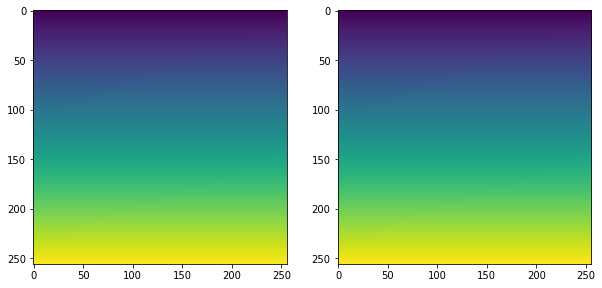

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(new_image.dataobj[:,:,80])
a = fig.add_subplot(1, 2, 2)
plt.imshow(new_image.dataobj[:,:,80])

# **Waste Old - Custom dataset generator**

In [ ]:
class Nifti_T1_T2_Dataset(Dataset):
    def __init__(self, T1_folder_path, T2_folder_path, patch_size=32, transforms=None):
        # stuff
        self.transforms = transforms
        self.T1_folder_path = T1_folder_path
        self.T2_folder_path = T2_folder_path
        self.length_of_T1= len(T1_folder_path)
        self.patch_size = patch_size
        
        
    def __getitem__(self, index):
        # read from T1 and T2 paths
        orig_nii_t2 = nb.load(str(image_paths_t2[index]))
        orig_nii_t1 = nb.load(str(image_paths_t1[index]))
        
        t1_img_np = np.array(orig_nii_t1.dataobj)
        t2_img_np = np.array(orig_nii_t2.dataobj)

        t1_img_tnsr = torch.from_numpy(t1_img_np)        
        t2_img_tnsr = torch.from_numpy(t2_img_np)  
        
        t1_last_dim = t1_img_tnsr.shape[2]
        t2_last_dim = t2_img_tnsr.shape[2]

        #Default assumption is that the last dim of all images are not above 170, else change the below function to include crop
        
        """
        Most of the T2 images and T1 images vary a bit in the last dim, The max value of the dim we found is around 160
        So pad all the values to get common dim 170.
        Without this number of patches can vary for each image if its dim changes

        Example:
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 130])
        0 torch.Size([2304, 16, 16, 16]) torch.Size([2048, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 112])
        1 torch.Size([2304, 16, 16, 16]) torch.Size([1792, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 116])
        2 torch.Size([2304, 16, 16, 16]) torch.Size([1792, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 28])
        3 torch.Size([2304, 16, 16, 16]) torch.Size([256, 16, 16, 16])
        torch.Size([256, 256, 150])
        torch.Size([256, 256, 120])
        4 torch.Size([2304, 16, 16, 16]) torch.Size([1792, 16, 16, 16])
        """
        
        t1_img_tnsr = torch.nn.functional.pad(t1_img_tnsr, (0, 170-t1_last_dim),mode="constant")
        t2_img_tnsr = torch.nn.functional.pad(t2_img_tnsr, (0, 170-t2_last_dim),mode="constant")


        t1_patches = t1_img_tnsr.unfold(2, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size).unfold(0, self.patch_size, self.patch_size)
        t1_patches = t1_patches.contiguous().view(-1, self.patch_size, self.patch_size, self.patch_size)

        t2_patches = t2_img_tnsr.unfold(2, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size).unfold(0, self.patch_size, self.patch_size)
        t2_patches = t2_patches.contiguous().view(-1, self.patch_size, self.patch_size, self.patch_size)
        
        """
        Adding a dummy channel dimension in between patches and height as channel is grayscale and required in downstream
        This is not added before patching as with dim as 1, patch creation is not easy.
        Example: [320, 32, 32, 32] ===> [320, 1, 32, 32, 32]
        """

        t1_patches = t1_patches[:,None,:,:]
        t2_patches = t2_patches[:,None,:,:]

        
        if self.transforms is not None:
            data = self.transforms(data)
        
        # If the transform variable is not empty
        # then it applies the operations in the transforms with the order that it is created.
        return (t1_patches, t2_patches)

    def __len__(self):
        return len(self.T1_folder_path) # of how many data(images?) you have
        


In [ ]:
# train_test_split = 0.7
# split_index = round(len(image_paths_t1) * 0.7)
# train_image_paths_t1 = image_paths_t1[:split_index]
# train_image_paths_t2 = image_paths_t2[:split_index]
# test_image_paths_t1 = image_paths_t1[split_index:]
# # test_image_paths_t2 = image_paths_t2[split_index:]

In [ ]:
# train_dataset = Nifti_T1_T2_Dataset( T1_folder_path=train_image_paths_t1, T2_folder_path= train_image_paths_t2, transforms=None)
# test_dataset = Nifti_T1_T2_Dataset( T1_folder_path=test_image_paths_t1, T2_folder_path= test_image_paths_t2, transforms=None)

In [ ]:
# train_loader = DataLoader(train_dataset,batch_size=2,shuffle=True)
# test_loader = DataLoader(test_dataset,batch_size=2,shuffle=True)

In [ ]:
test_image_t2 = nb.load(test_image_paths_t2)
test_image_after_reconstruction_t1  = transforms.ToPILImage()(output_final)

%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(test_image_after_reconstruction_t1.dataobj[:,:,80])
a = fig.add_subplot(1, 2, 2)
plt.imshow(test_image_t2.dataobj[:,:,80])

In [ ]:
orig_nii_t1 = nb.load("/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/IXI-T1/IXI595-IOP-1159-T1.nii.gz")
orig_nii_t2 = nb.load("/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/IXI-T2/IXI595-IOP-1159-T2.nii.gz")

print(orig_nii_t1.shape)
print(orig_nii_t2.shape)

(256, 256, 146)
(256, 256, 136)


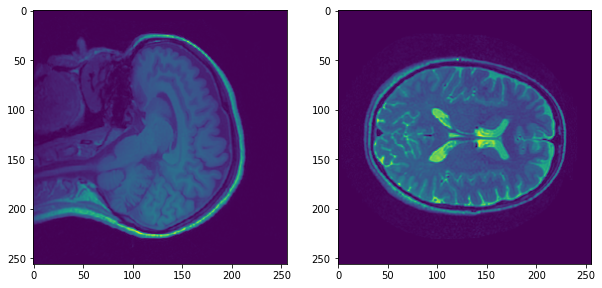

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(orig_nii_t1.dataobj[:,:,80])
a = fig.add_subplot(1, 2, 2)
plt.imshow(orig_nii_t2.dataobj[:,:,80])

In [ ]:
downsampled_nii_t1 = resample_img(orig_nii_t1, target_affine=np.eye(3)*2., interpolation='nearest')

In [ ]:
downsampled_nii_t1.shape

(90, 121, 122)

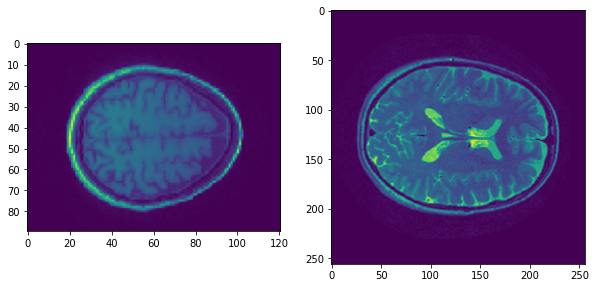

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(downsampled_nii_t1.dataobj[:,:,80])
a = fig.add_subplot(1, 2, 2)
plt.imshow(orig_nii_t2.dataobj[:,:,80])

In [ ]:
target_shape = np.array((128,128,100))
new_resolution = [2,]*3
new_affine = np.zeros((4,4))
new_affine[:3,:3] = np.diag(new_resolution)
# putting point 0,0,0 in the middle of the new volume - this could be refined in the future
new_affine[:3,3] = target_shape*new_resolution/2.*-1
new_affine[3,3] = 1

downsampled_and_cropped_nii_t1 = resample_img(orig_nii_t1,target_affine=new_affine,target_shape=target_shape, interpolation='nearest')
downsampled_and_cropped_nii_t2 = resample_img(orig_nii_t2,target_affine=new_affine,target_shape=target_shape, interpolation='nearest')

In [ ]:
print(downsampled_and_cropped_nii_t1.shape)
print(downsampled_and_cropped_nii_t2.shape)

(128, 128, 100)
(128, 128, 100)


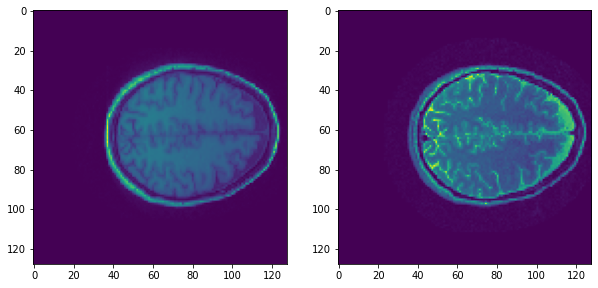

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(downsampled_and_cropped_nii_t1.dataobj[:,:,80])
a = fig.add_subplot(1, 2, 2)
plt.imshow(downsampled_and_cropped_nii_t2.dataobj[:,:,80])

# **Old - Evaluation**



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

# Take one random image
test_image_paths_t1 = [image_paths_t1[550]]
test_image_paths_t2 = [image_paths_t2[550]]

# Creating dataset 
test_dataset = Nifti_T1_T2_Dataset( T1_folder_path=test_image_paths_t1, T2_folder_path= test_image_paths_t2, transforms=None)
print(len(test_dataset))

#  Printing for test dataset
for i in range(len(test_dataset)):
    sample = test_dataset[i]
    print(i, sample[0].shape, sample[1].shape)

test_patches_dataset = Patching(patches=test_dataset)

# Data loader for test data
test_patches_loader = DataLoader(test_patches_dataset,batch_size=16,shuffle=True, pin_memory=False)

# Load the model
trained_model = torch.load("/content/drive/My Drive/Colab Notebooks/ImageRegistrationUsingDeepLearning/unet.pth")
trained_model.eval()

# patches = []
for i, data in enumerate(test_patches_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # patches  
        outputs = trained_model(inputs)  
        
        # append each output here to get tensor of patches.

        # patches.append(outputs)

        # del inputs
        # del labels
        # del outputs 


# Method 1: Reshape back
unfold_shape = outputs.size()
patches_orig = outputs.view(unfold_shape)


output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
output_final = patches_orig.view(1, output_c, output_h, output_w)


# Method 2: # Reference from:  https://stackoverflow.com/questions/62995726/pytorch-sliding-window-with-unfold-fold
# output = F.fold(outputs, output_size=(256, 256),kernel_size=32, stride=32)
# # mask that mimics the original folding:
# recovery_mask = F.fold(torch.ones_like(outputs), output_size=(256,256),kernel_size=32,stride=32)
# output = output/recovery_mask
# print(output.shape) # [B, C, H, W]

1
0 torch.Size([320, 1, 32, 32, 32]) torch.Size([320, 1, 32, 32, 32])


IndexError: ignored

In [ ]:
# visualization 

from torchvision import transforms
test_image_paths_t2 = image_paths_t2[550]

test_image_t2 = nb.load(test_image_paths_t2)
test_image_after_reconstruction_t1  = transforms.ToPILImage()(output_final)

%matplotlib inline
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(test_image_after_reconstruction_t1.dataobj[:,:,80])
a = fig.add_subplot(1, 2, 2)
plt.imshow(test_image_t2.dataobj[:,:,80])

In [ ]:

#  Random example , Reference from - https://discuss.pytorch.org/t/creating-nonoverlapping-patches-from-3d-data-and-reshape-them-back-to-the-image/51210/6
x = torch.randn(1, 172, 220, 156)
kc, kh, kw = 32, 32, 32  # kernel size
dc, dh, dw = 32, 32, 32  # stride
# Pad to multiples of 32
x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
              x.size(1)%kh // 2, x.size(1)%kh // 2,
              x.size(0)%kc // 2, x.size(0)%kc // 2))

patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
# print("1" + str(patches))
unfold_shape = patches.size()
print("2" + str(unfold_shape))
patches = patches.contiguous().view(-1, kc, kh, kw)
print(print("3" + str(patches.shape)))

# Reshape back
patches_orig = patches.view(unfold_shape)
# print("4" + str(patches_orig))
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())
print(x[:, :output_c, :output_h, :output_w].shape)

2torch.Size([1, 5, 7, 5, 32, 32, 32])
3torch.Size([175, 32, 32, 32])
None
tensor(True)
torch.Size([1, 160, 224, 160])


In [ ]:
unet_model = torch.load("/content/drive/My Drive/Colab Notebooks/image_registration/unet.pth")
unet_model.eval()
unet_model = unet_model.to(device=device)

In [ ]:
stacked_tensor = []

In [ ]:
for i, data in enumerate(test_patches_loader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # patches  
        outputs = unet_model(inputs)  
        print(outputs.shape)
        
        stacked_tensor.append(outputs)
        del inputs
        del labels
        del outputs



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([16, 1, 32, 32, 32])
torch.Size([16, 1, 32, 32, 32])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
len(stacked_tensor)

20

In [ ]:
#stk = torch.stack(stacked_tensor,dim=1)
#stk.shape


torch.Size([16, 20, 1, 32, 32, 32])

**Concatenated patches**

In [ ]:
cnct = torch.cat(stacked_tensor,dim=0)
print(cnct.shape)
cnct = cnct.squeeze(dim=1)
print(cnct.shape)

torch.Size([320, 1, 32, 32, 32])
torch.Size([320, 32, 32, 32])


In [ ]:
#t2_patches = t2_img_tnsr.unfold(2, self.patch_size, self.patch_size).unfold(1, self.patch_size, self.patch_size).unfold(0, self.patch_size, self.patch_size)
#        t2_patches = t2_patches.contiguous().view(-1, self.patch_size, self.patch_size, self.patch_size)

In [ ]:
# @suraj: size of the original tensor after padding
x = torch.randn(1, 256, 256, 170)
print("size of T1 tesor before processing and after pading: {}".format(str(x.shape)))
kc, kh, kw = 32, 32, 32  # kernel size
dc, dh, dw = 32, 32, 32  # stride
# Pad to multiples of 32
x = F.pad(x, (x.size(2)%kw // 2, x.size(2)%kw // 2,
              x.size(1)%kh // 2, x.size(1)%kh // 2,
              x.size(0)%kc // 2, x.size(0)%kc // 2))

#patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
#unfold_shape = patches.size()
#patches = patches.contiguous().view(-1, kc, kh, kw)
#print(patches.shape)


#@suraj: Using our concatanted patches

print("size of processed T2 patches from model: {}".format(str(cnct.shape)))

#@suraj: Moving the tensor from gpu to cpu
patches = cnct.to(device="cpu")

# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
print("Predicted Shape of the T2 output after stiching : {}",format(str(patches_orig.shape)))
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

print(output_c, output_h, output_w)
# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())
print(patches_orig.shape)
print("Actual Shape of the T2 output after stiching : {}",format(str(patches_orig.shape)))
#tensor(1, dtype=torch.uint8)


size of T1 tesor before processing and after pading: torch.Size([1, 256, 256, 170])
size of processed T2 patches from model: torch.Size([320, 32, 32, 32])
Predicted Shape of the T2 output after stiching : {} torch.Size([1, 8, 8, 5, 32, 32, 32])
256 256 160
tensor(False)
torch.Size([1, 256, 256, 160])
Actual Shape of the T2 output after stiching : {} torch.Size([1, 256, 256, 160])
